# Abstract

In [57]:
%load_ext autoreload
%autoreload 2
from logisticNewtonAdam import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Newton's Method

# Testing Newton Method Implementation
In order to test the correctness of the Newton's Method implementation, I will demonstrate for a sufficiently small learning rate `α`, Newton's Method coverges to the same result that regular gradient descent would achieve. 

# Generating Classification Data
To test Newton's Method optimization against standard gradient descent, we will generate a 2d set of binary classification data with the `generate_classification_data` function below. 

In [139]:
import torch
def generate_classification_data(n_points = 300, noise = 0.5, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = generate_classification_data(noise = 0.5)
print(f"X: {X}\ny: {y}")

X: tensor([[ 0.1331, -0.5069,  1.0000],
        [ 0.4187,  0.5261,  1.0000],
        [-0.2983,  0.6095,  1.0000],
        [-0.2762, -0.2033,  1.0000],
        [-0.2627,  0.2448,  1.0000],
        [-0.2522,  0.0076,  1.0000],
        [ 0.2728, -0.3588,  1.0000],
        [-0.4089,  0.1683,  1.0000],
        [-0.6963, -0.0694,  1.0000],
        [-0.2051,  0.4304,  1.0000],
        [ 0.1909, -0.8464,  1.0000],
        [ 0.1166,  0.1731,  1.0000],
        [ 1.1864,  0.5177,  1.0000],
        [ 0.3620, -0.3833,  1.0000],
        [-0.6120, -0.4335,  1.0000],
        [-0.0809,  0.8607,  1.0000],
        [-0.5815,  0.1353,  1.0000],
        [ 0.3168, -1.1318,  1.0000],
        [ 0.1718,  0.3886,  1.0000],
        [-0.3228, -0.1408,  1.0000],
        [-0.5979,  0.0414,  1.0000],
        [-0.6130,  0.2337,  1.0000],
        [ 0.2476,  0.1517,  1.0000],
        [-0.6775,  0.0802,  1.0000],
        [-0.4850, -0.1069,  1.0000],
        [ 0.1449,  0.6849,  1.0000],
        [-0.3816,  0.0954,  1.0000]

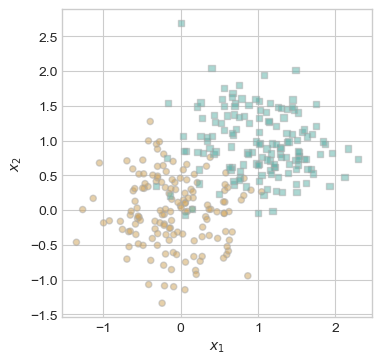

In [59]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_classification_data(X, y, ax)


# Experiments
Now that we have some a binary classification dataset, we can use it to perform various experiments to fully illstrate Newton's Method opitimization.

## Experiment 1: Comparing Standard Graident Descent and Newton's Method
Now that we have a binary classification dataset, we can declare two Logistic Regression models, one that will use the standard gradient opitimzer and one that will use Newton's Method optimization.

# Palmers Penguins Dataset for Experiements

In [ ]:
import pandas as pd
train = pd.read_csv("breast-cancer.csv")

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Data Preprocessing

In [ ]:
# from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

def prepare_data(df):
    df = df.dropna()
    y = np.where(df['diagnosis'] == "M", True, False)
    df = df.drop(['diagnosis'], axis = 1)
    df = df.drop(['id'], axis = 1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return X_scaled, y

X, y = prepare_data(train)
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y).float()
X = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=0.20, random_state=42)
# X_train, X_validate, y_train, y_validate = train_test_split(
#     X_train, y_train, test_size=0.20, random_state=42)


In [240]:
# Logistic Regression model with gradient descent optimizer
LR_GD = LogisticRegression()
opt_GD = GradientDescentOptimizer(LR_GD)

#Logistic Regression model with Newton's Method optimizer 
LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)

num_iterations = 1000
for _ in range(num_iterations):
    opt_GD.step(X, y, 0.1, 0, False, 0)
    opt_NM.step(X, y, 1)
print(f"Gradient Descent Logistic Regression Loss: {LR_GD.loss(X,y)}\nNewton's Method Logistic Regression Loss: {LR_NM.loss(X,y)}\n")



Gradient Descent Logistic Regression Loss: 0.05876803398132324
Newton's Method Logistic Regression Loss: 0.08070827275514603



# Results
We can see that when giving the standard gradient descent optimizer a learning rate of `0.1` and the Newton's Method optimizer a learning rate of `1`, they produce a similar loss in the same amount of iterations.

## Experiment 2: Faster Convergence Using Newton's Method
Through this experiment I will demonstrate that Newton's Method in certain circumstances can have a much faster convergence than Standard Gradient Descent optimizaiton. The circumstance shown below is when the data has low noise and low number of points and dimensions. In this case, Newton's Method is able to converge faster than standard gradient descent.

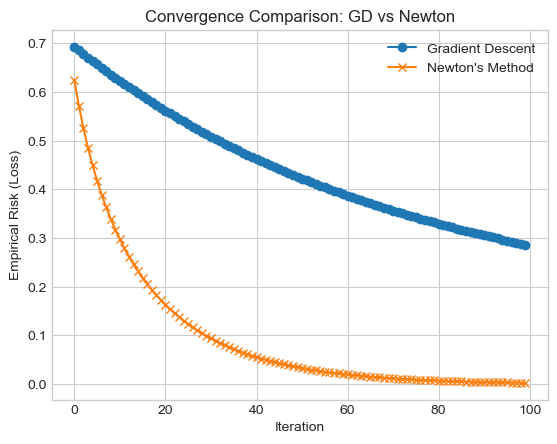

In [248]:
LR_GD = LogisticRegression()
opt_GD = GradientDescentOptimizer(LR_GD)

#Logistic Regression model with Newton's Method optimizer 
LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)
# Track loss over iterations
losses_gd = []
losses_nm = []

# Training loop
n_steps = 100
for _ in range(n_steps):
    # Gradient Descent
    opt_GD.step(X, y, 0.1, 0, False, 0)
    loss_gd = LR_GD.loss(X, y).item()
    losses_gd.append(loss_gd)

    # Newton's Method
    opt_NM.step(X, y, alpha=100)
    loss_nm = LR_NM.loss(X, y).item()
    losses_nm.append(loss_nm)

# Plot convergence
plt.plot(losses_gd, label="Gradient Descent", marker='o')
plt.plot(losses_nm, label="Newton's Method", marker='x')
plt.xlabel("Iteration")
plt.ylabel("Empirical Risk (Loss)")
plt.title("Convergence Comparison: GD vs Newton")
plt.legend()
plt.grid(True)
plt.show()

# Results
As demonsrated by the graph, in 100 iterations optimization with Newton's Method reaches near zero loss, while the loss using standard gradient descent for optimization is around `0.25`.

## Experiment 3: Newton's Method Fails to Converge When Learing Rate is Large
Now, I will demonstrate how a large learning rate can cause Newton's Method to fail to converge at all.

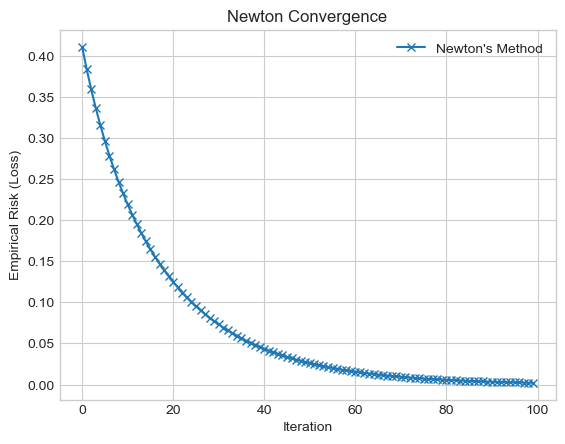

In [247]:
# X, y = generate_classification_data(noise = 0.01, p_dims=2, n_points=2000)

LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)
# Track loss over iterations
losses_nm = []

# Training loop
n_steps = 100
for _ in range(n_steps):
    # Newton's Method
    opt_NM.step(X, y, alpha=100)
    loss_nm = LR_NM.loss(X, y).item()
    losses_nm.append(loss_nm)

# Plot convergence
plt.plot(losses_nm, label="Newton's Method", marker='x')
plt.xlabel("Iteration")
plt.ylabel("Empirical Risk (Loss)")
plt.title("Newton Convergence")
plt.legend()
plt.grid(True)

# Adam Optimization

In [ ]:
LR_Adam = LogisticRegression()
opt_Adam = AdamOptimizer(LR_Adam)

num_iterations = 1000
for _ in range(num_iterations):
    # Using the same dataset X and y as with newtons method
    opt_Adam.step(X, y, 0.01, 0.9, 0.999, 1e-8, 10)
print(f"Gradient Descent Logistic Regression Loss: {LR_Adam.loss(X,y)}")

Gradient Descent Logistic Regression Loss: 0.20271477103233337


# Comparing Adam Optimzation and Standard Minibatch Gradient Descent

In [184]:
import pandas as pd

num_iterations = 1000
step_size = [0.0001, 0.001, 0.01, 0.1, 1]

minibatch_GD_loss = []
adam_OPT_loss = []

for step in step_size: 
    LR_GD = LogisticRegression()
    opt_GD = GradientDescentOptimizer(LR_GD)

    LR_Adam = LogisticRegression()
    opt_Adam = AdamOptimizer(LR_Adam)

    for _ in range(num_iterations):
        # Using the same dataset X and y as with newtons method
        opt_Adam.step(X, y, step, 0.9, 0.999, 1e-8, 10)
        opt_GD.step(X, y, step, 0.9, True, 10)
    adam_OPT_loss.append(LR_Adam.loss(X, y).item())
    minibatch_GD_loss.append(LR_GD.loss(X, y).item())
# Make some type of table
#first convert to series
df = pd.DataFrame({
    "Minibatch GD Loss": minibatch_GD_loss,
    "Adam Optimizer Loss": adam_OPT_loss
}, index=step_size)

print(df)

        Minibatch GD Loss  Adam Optimizer Loss
0.0001           1.537306             1.534232
0.0010           1.546394             1.091133
0.0100           0.872059             0.018603
0.1000           0.008254             0.001868
1.0000           0.000414             0.152991


# Results
On average with the same batch size of 10, using the adam opitmizer converges faster than standard minibatch gradient descent when both optimizers have matching alpha values.

# Comparing Adam and Newton's Method Optimization

In [185]:
import time

X, y = generate_classification_data(noise = 0.8)
LR_Adam = LogisticRegression()
opt_Adam = AdamOptimizer(LR_Adam)

LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)


LOSS_THRESHOLD = 0.2
MAX_ITER = 1000

start_adam = time.time()

for _ in range(MAX_ITER):
    opt_Adam.step(X, y, step, 0.9, 0.999, 1e-8, 10)
    loss = LR_Adam.loss(X, y).item()
    if loss < LOSS_THRESHOLD:
        break

end_adam = time.time()
adam_time = end_adam - start_adam

start_newton = time.time()

for _ in range(MAX_ITER):
    opt_NM.step(X, y, 0.9)
    loss = LR_NM.loss(X, y).item()
    if loss < LOSS_THRESHOLD:
        break

end_newton = time.time()
newton_time = end_newton - start_newton

print(f"Newton's Method Optimization converge time: {newton_time}\nAdam Optimization converge time: {adam_time}")


Newton's Method Optimization converge time: 0.043290138244628906
Adam Optimization converge time: 0.06393694877624512


# Results
Seems like Newton's Method converges faster than Adam Optimization on this dataset.

# Results
Here, we demonstrate that Logistic Regression using either Newton's Method or Gradient Descent optimization can converge to a similar value given enough iterations and a small enough learning rate `α`.